<a href="https://colab.research.google.com/github/SiHanWang2Developer/data/blob/master/pointrend%E6%9C%89546%E6%95%B0%E6%8D%AE%E8%AE%AD%E7%BB%8318000%E6%AC%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [How to train Detectron2 with Custom COCO Datasets](https://www.dlology.com/blog/how-to-train-detectron2-with-custom-coco-datasets/) | DLology

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

This notebook will help you get started with this framwork by training a instance segmentation model with your custom COCO datasets.

本文参考https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
!/opt/bin/nvidia-smi

Sat Jun 20 03:37:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Install detectron2

In [2]:
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
# !pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 43.1MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=600bed44fea2cf1b89c76962348df38025bd4d38f9b848e50404fc1ad76cd497
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-r

'1.4.0+cu100'

In [3]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
# clone the repo to access PointRend code. Use the same version as the installed detectron2
!git clone --branch v0.1.1 https://github.com/facebookresearch/detectron2 detectron2_repo

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 5.9MB 840kB/s 
Cloning into 'detectron2_repo'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 5558 (delta 1), reused 3 (delta 1), pack-reused 5550
Receiving objects: 100% (5558/5558), 2.56 MiB | 2.42 MiB/s, done.
Resolving deltas: 100% (4005/4005), done.
Note: checking out '401fd04cecec16f1ed0452eb936502d5d33a23be'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import PointRend project
import sys; sys.path.insert(1, "detectron2_repo/projects/PointRend")
from detectron2_repo.projects.PointRend import point_rend

# Train on a custom COCO dataset

In this section, we show how to train an existing detectron2 model on a custom dataset in a new format.

We use [the fruits nuts segmentation dataset](https://github.com/Tony607/mmdetection_instance_segmentation_demo)
which only has 3 classes: data, fig, and hazelnut.
We'll train a segmentation model from an existing model pre-trained on the COCO dataset, available in detectron2's model zoo.

Note that the COCO dataset does not have the "data", "fig" and "hazelnut" categories.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Register the fruits_nuts dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).




---


下面 笔画数据集



In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("L", {}, "./drive/My Drive/LGQ546/train546.json", "./drive/My Drive/LGQ546/imgs")
wanzheng_metadata = MetadataCatalog.get("L")
wanzhengdataset_dicts = DatasetCatalog.get("L")

[06/20 03:53:15 d2.data.datasets.coco]: Loaded 546 images in COCO format from ./drive/My Drive/LGQ546/train546.json


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



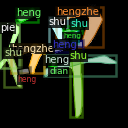

In [7]:
#笔画数据集
import random
for d in random.sample(wanzhengdataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=wanzheng_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the fruits_nuts dataset. It takes ~6 minutes to train 300 iterations on Colab's K80 GPU.


## MaskRCNN模型

In [ ]:
# 创建MaskRCNN模型
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg1 = get_cfg()
cfg1.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg1.DATASETS.TRAIN = ("wz1100A",)
cfg1.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg1.DATALOADER.NUM_WORKERS = 4
cfg1.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg1.SOLVER.IMS_PER_BATCH = 10
cfg1.SOLVER.BASE_LR = 0.02
cfg1.SOLVER.MAX_ITER = 8000    # 300 iterations seems good enough, but you can certainly train longer
cfg1.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg1.MODEL.ROI_HEADS.NUM_CLASSES = 32 # 32 classes (data, fig, hazelnut)
cfg1.OUTPUT_DIR='outputMRCNN'
os.makedirs(cfg1.OUTPUT_DIR, exist_ok=True)
MRCNNtrainer = DefaultTrainer(cfg1)
MRCNNtrainer.resume_or_load(resume=False)
MRCNNtrainer.train()

[04/19 12:04:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:17, 10.4MB/s]                           
'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (33, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (33,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (128, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (128,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (32, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (32,) in the model! Skipped.


[04/19 12:05:17 d2.engine.train_loop]: Starting training from iteration 0
[04/19 12:05:38 d2.utils.events]:  eta: 2:19:04  iter: 19  total_loss: 4.240  loss_cls: 2.590  loss_box_reg: 0.822  loss_mask: 0.686  loss_rpn_cls: 0.109  loss_rpn_loc: 0.057  time: 1.0399  data_time: 0.0790  lr: 0.000400  max_mem: 8731M
[04/19 12:05:58 d2.utils.events]:  eta: 2:16:21  iter: 39  total_loss: 2.554  loss_cls: 1.078  loss_box_reg: 0.839  loss_mask: 0.552  loss_rpn_cls: 0.022  loss_rpn_loc: 0.043  time: 1.0328  data_time: 0.0625  lr: 0.000799  max_mem: 8731M
[04/19 12:06:19 d2.utils.events]:  eta: 2:18:36  iter: 59  total_loss: 2.159  loss_cls: 0.931  loss_box_reg: 0.815  loss_mask: 0.360  loss_rpn_cls: 0.019  loss_rpn_loc: 0.041  time: 1.0378  data_time: 0.0621  lr: 0.001199  max_mem: 8731M
[04/19 12:06:40 d2.utils.events]:  eta: 2:19:03  iter: 79  total_loss: 1.894  loss_cls: 0.855  loss_box_reg: 0.768  loss_mask: 0.225  loss_rpn_cls: 0.011  loss_rpn_loc: 0.036  time: 1.0431  data_time: 0.0699  lr:

In [ ]:
## 创建MaskRCNN模型
cfg1.MODEL.WEIGHTS = os.path.join(cfg1.OUTPUT_DIR, "model_final.pth")
cfg1.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg1.DATASETS.TEST = ("wz", )
MRCNNpredictor = DefaultPredictor(cfg1)

from detectron2.utils.visualizer import ColorMode

for d in random.sample(wanzhengdataset_dicts, 1):    
    # im = cv2.imread(d["file_name"])
    im = cv2.imread('/content/drive/My Drive/pic566_28class/images/000545.jpg')
    outputs = MRCNNpredictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wanzheng_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels用于实例化可视化的不同颜色模式  IMAGE_BW：与IMAGE相同，但将所有不带遮罩的区域转换为灰度。仅适用于按实例绘制蒙版预测
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


    #如何输出单独的mask
    masks=np.asarray(outputs["instances"].to("cpu").pred_masks)#[n,256,256]n为笔画数
    count=0
    for mask in masks:
      mask=mask.astype("uint8")#mask从[false,flase]到[00001100]
      mask=mask*255       #变成二值图
      cv2_imshow(mask)

      count=count+1
      # file_path="/content/"+str(count)+".jpg"
      # cv2.imwrite(file_path,mask)

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir outputMRCNN

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wz", cfg1, False, output_dir="./outputMRCNN/")#output_dir可选的输出目录，用于转储数据集上预测的所有结果。转储包含两个文件 "instance_predictions.pth" “ coco_instances_results.json”
val_loader = build_detection_test_loader(cfg1, "wz")
inference_on_dataset(MRCNNtrainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test


In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = MRCNNpredictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

## Pointrend模型

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()

# Add PointRend-specific config
point_rend.add_pointrend_config(cfg)
cfg.MODEL.POINT_HEAD.NUM_CLASSES = 28 #修改POINT_HEAD.NUM_CLASSES 32 默认值为80


cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco.yaml")
cfg.DATASETS.TRAIN = ("L",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/PointRend/InstanceSegmentation/pointrend_rcnn_R_50_FPN_3x_coco/164955410/model_final_3c3198.pkl" # initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 10
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 18000    # 3000 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE =128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 28  # 28 classes (heng,shu....)
cfg.OUTPUT_DIR= '/content/drive/My Drive/lgq18000'

#正式训练
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/20 03:53:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_3c3198.pkl: 241MB [00:21, 11.5MB/s]                           
Unable to load 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (29, 1024) in the model!
Unable to load 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (29,) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (112, 1024) in the model!
Unable to load 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (112,) in the model!


[06/20 03:54:22 d2.engine.train_loop]: Starting training from iteration 0
[06/20 03:54:58 d2.utils.events]:  eta: 8:23:52  iter: 19  total_loss: 4.938  loss_cls: 3.151  loss_box_reg: 0.853  loss_rpn_cls: 0.850  loss_rpn_loc: 0.107  time: 1.7498  data_time: 1.1827  lr: 0.000005  max_mem: 7143M
[06/20 03:55:28 d2.utils.events]:  eta: 7:47:51  iter: 39  total_loss: 4.590  loss_cls: 2.927  loss_box_reg: 0.888  loss_rpn_cls: 0.644  loss_rpn_loc: 0.111  time: 1.6253  data_time: 0.8872  lr: 0.000010  max_mem: 7143M


In [ ]:
print(cfg)

Now, we perform inference with the trained model on the fruits_nuts dataset. First, let's create a predictor using the model we just trained:



In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir  output

## inference

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("L", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

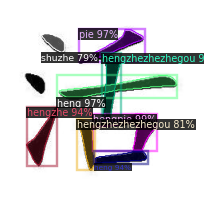

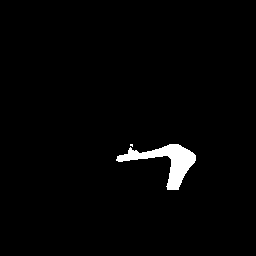

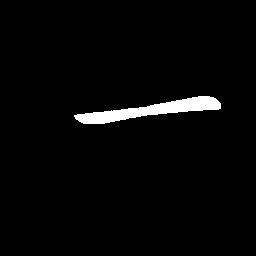

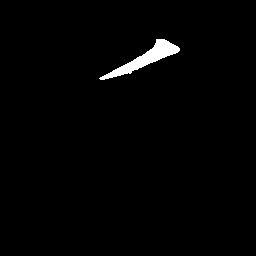

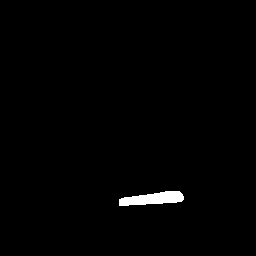

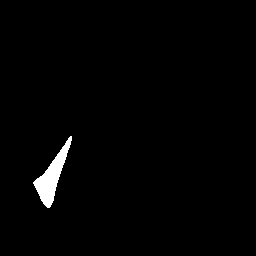

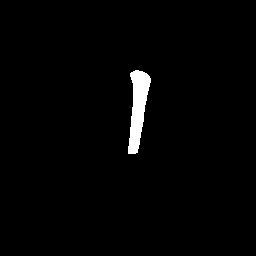

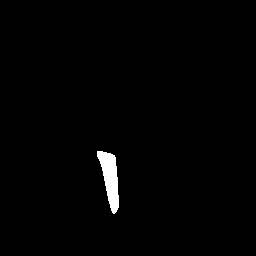

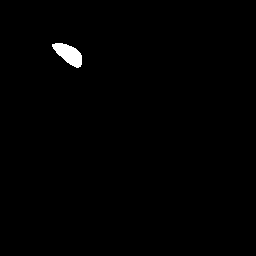

In [ ]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(wanzhengdataset_dicts, 1):    
#     im = cv2.imread(d["file_name"])
    im = cv2.imread('/content/drive/My Drive/pic566_28class/images/000545.jpg') #使用活字 的图片
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=wanzheng_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels用于实例化可视化的不同颜色模式  IMAGE_BW：与IMAGE相同，但将所有不带遮罩的区域转换为灰度。仅适用于按实例绘制蒙版预测
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])


    #如何输出单独的mask
    masks=np.asarray(outputs["instances"].to("cpu").pred_masks)#[n,256,256]n为笔画数
    count=0
    for mask in masks:
      mask=mask.astype("uint8")#mask从[false,flase]到[00001100]
      mask=mask*255       #变成二值图
      cv2_imshow(mask)

      count=count+1
      file_path="/content/"+str(count)+".jpg"
      cv2.imwrite(file_path,mask)


In [ ]:
wanzheng_metadata

Metadata(evaluator_type='coco', image_root='./drive/My Drive/pic566_28class/images', json_file='./drive/My Drive/pic566_28class/images566.json', name='wzInfer', thing_classes=['piezhe', 'heng', 'hengzhewangou', 'pie', 'na', 'shuwangou', 'henggou', 'shugou', 'hengzhegou', 'hengzhezhezhegou', 'hengpie', 'shu', 'shuzhezhegou', 'dian', 'wangou', 'ti', 'shuti', 'shuzhe', 'wogou', 'hengzhe', 'xiegou', 'hengzhezhepie', 'hengzhewan', 'piedian', 'shuzhepie', 'hengxiegou', 'hengzheti', 'shuwan'], thing_dataset_id_to_contiguous_id={1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27})

We can also evaluate its performance using AP metric implemented in COCO API. This gives an AP of ~70%. Not bad!

In [ ]:
print(cfg)

CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 4
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ('wzInfer',)
  TRAIN: ('wz',)
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: bitmask
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0], [0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resnet_fpn_backbone
  DEVICE: cuda
  FPN:
    FUSE_TYPE: sum
   

## **检验效果---AP**

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wz", cfg, False, output_dir="./output/")#output_dir可选的输出目录，用于转储数据集上预测的所有结果。转储包含两个文件 "instance_predictions.pth" “ coco_instances_results.json”
val_loader = build_detection_test_loader(cfg, "wz")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test


[04/19 11:57:14 d2.data.datasets.coco]: Loaded 680 images in COCO format from ./drive/My Drive/pic32/train.json
[04/19 11:57:14 d2.data.build]: Distribution of instances among all 32 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|    piezhe     | 76           |     heng      | 1025         | hengzhewangou | 21           |
|      pie      | 828          |      na       | 200          |   shuwangou   | 56           |
|    henggou    | 47           |    shugou     | 109          |   shuzhezhe   | 11           |
|      shu      | 600          |    hengzhe    | 173          |  hengzhegou   | 157          |
| hengzhezhezhe | 5            | hengzhezhez.. | 9            |    hengpie    | 67           |
|  hengzhezhe   | 11           | shuzhezhegou  | 18           |     dian      | 328          |
|    wangou     | 22           |      ti     

OrderedDict([('bbox',
              {'AP': 86.44821402532902,
               'AP-dian': 74.51679407539574,
               'AP-heng': 79.16831918641024,
               'AP-henggou': 80.04840441275499,
               'AP-hengpie': 91.39495832830366,
               'AP-hengpiewangou': 90.2121640735502,
               'AP-hengxiegou': 86.66116611661167,
               'AP-hengzhe': 78.49187895177208,
               'AP-hengzhegou': 85.30686159841957,
               'AP-hengzheti': 71.11881188118811,
               'AP-hengzhewan': 94.04172560113155,
               'AP-hengzhewangou': 92.92209484106306,
               'AP-hengzhezhe': 94.55445544554455,
               'AP-hengzhezhepie': 91.62530869791784,
               'AP-hengzhezhezhe': 100.0,
               'AP-hengzhezhezhegou': 78.56435643564356,
               'AP-na': 89.30098745098854,
               'AP-pie': 85.48464326083361,
               'AP-piedian': 89.7112211221122,
               'AP-piezhe': 86.59821861051617,
         

## Benchmark inference speed

In [ ]:
import time
times = []
for i in range(20):
    start_time = time.time()
    outputs = predictor(im)
    delta = time.time() - start_time
    times.append(delta)
mean_delta = np.array(times).mean()
fps = 1 / mean_delta
print("Average(sec):{:.2f},fps:{:.2f}".format(mean_delta, fps))

Average(sec):0.08,fps:12.78
